In this notebok we will try to create a model that generates jokes. What's different in this is that we will build everything from scratch using the TF2.0 API. 

The GPT2 model was pretrained on vast amount of data for days by HuggingFace. The model already knew the English language structures and context. We were only tweaking it for our own dataset. 

In this notebook we are creating our own model with random weights so we cannot expect the learning to be as accurate and fast as the GPT2 one. Yet it serves the purpose of providing a deeper understanding of how things are working inside the Transformer.


*Note:* The code for this notebook is mainly based on the code provided in the tutorial: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb.

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

## Downloading the Data

The dataset is available at https://www.kaggle.com/abhinavmoudgil95/short-jokes/data

Sign In to Kaggle and begin the download process for **shortjokes.csv** file. Then copy the link address for the download file and update the _URL varaiable.

Once done run all the cells in the notebook. Also, you can cancel the donwload process for the file. :)

In [0]:
_URL = 'https://storage.googleapis.com/kaggle-data-sets/781%2F1457%2Fcompressed%2Fshortjokes.csv.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1591366620&Signature=B62abmVrT%2BrxZx98Vr4GcGpSGV8nTSmQVG7qBr771XvAfs7lQIgg0OQNGmhHAJ3BUlXTdTPh93RH45jtojG7qdec86oV%2FyXYk6HxyvDZgNzkC6vQsZv7A4WFt1Q9EZPBzhimECVrGwq5KwmwSDPntEYiZwQ9xHOvyefomUhLkUYpoi5xFbf%2BO79c2iAekgwbYLyAG%2BTNmVF4CGBCnlj%2F%2FqYT0anHefFnIfQ26msN3njQEq%2BMPLafSNAWGZYeZmvX8TAIZqkHz8VlgnpahK%2Bp3%2B0WUTWSTlii03q1JcAumVwB%2Fg2uByPlASohVNqqd1pkpLRpVuSsA%2BewR%2BdyGobhDw%3D%3D'

In [3]:
path_to_zip = tf.keras.utils.get_file('shortjokes.csv.zip', origin=_URL, extract=True)

FILE_PATH = os.path.join(os.path.dirname(path_to_zip), 'shortjokes.csv')

10305536/10299687 [==============================] - 0s 0us/step


## Preparing the Data

### Extracting jokes list from CSV

In [4]:
jokes = pd.read_csv(FILE_PATH)
jokes.head()

,ID,Joke
0,1,"[me narrating a documentary about narrators] ""..."
1,2,Telling my daughter garlic is good for you. Go...
2,3,I've been going through a really rough period ...
3,4,"If I could have dinner with anyone, dead or al..."
4,5,Two guys walk into a bar. The third guy ducks.


In [0]:
jokeslist = jokes['Joke'].to_list()

### Creating the Tokenizer

We first need to build our tokenizer from the corpus that we have.

In [0]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      jokeslist,
      target_vocab_size=50000
  )

In [7]:
tokenizer.vocab_size

48089

We add 2 tokens -> The start token and end token to our vocab thus our VOCAB_SIZE will have 2 added elements

In [0]:
# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [0]:
MAX_LENGTH = 64

## This function tokenizes the sentences with our tokenzier and also pads it 
## so that each is of size MAX_LENGTH
def tokenize(sentence_list):
  
  ## Add start token and end token to the tokenized output of each sentence
  tokenized_sentence_list = [
    START_TOKEN + tokenizer.encode(sentence) + END_TOKEN \
    for sentence in sentence_list
  ]

  padded_list = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_sentence_list, maxlen = MAX_LENGTH, padding='post'
  )

  return padded_list

In [10]:
jokes_as_tokens = tokenize(jokeslist)

jokes_as_tokens[0]

array([48089, 47924,    34, 15902,     1,  4310,    46, 42599, 47948,
         658,     3,    89, 47872,    14,   110,    77,   171, 47872,
          57,   719,  2820, 47906, 47872,    36,  2977, 47867, 48090,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [0]:
# A utility method to create a tf.data dataset from a List of jokes
def tokenslist_to_dataset(tokens_list, 
                  shuffle=True, batch_size=64):

  ## In our dataset the y_true will be 1 unit shifted version of 
  ## the input data. Thus we ignore the last index in X and the zeroth 
  ## index in y
  dataset = tf.data.Dataset.from_tensor_slices(( 
          tokens_list[:, :-1],
          tokens_list[:, 1:]
  ))

  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(tokens_list))

  dataset = dataset.batch(batch_size)

  return dataset

In [0]:
jokes_dataset = tokenslist_to_dataset(jokes_as_tokens)

In [13]:
for batchX, batchY in jokes_dataset:
  print(batchX[0], batchY[0])
  break

tf.Tensor(
[48089   943   157 47914     7    16    18   160   309    25   134 47872
     9  1453     2  1987    12   334   305    10   258  2097   209   125
    49  1557     1   503     4 47898     7  1364  3617  5843 48090     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0], shape=(63,), dtype=int32) tf.Tensor(
[  943   157 47914     7    16    18   160   309    25   134 47872     9
  1453     2  1987    12   334   305    10   258  2097   209   125    49
  1557     1   503     4 47898     7  1364  3617  5843 48090     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0], shape=(63,), dtype=int32)


As can be seen we our dataset is correctly providing the shifted version of our X in our expected Y values. We can thus move on to build our model.

## Attention

### Masked Self Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [0]:
def masked_self_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

### Multi-head attention Layer


Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Masked Self attention.
* Concatenation of heads.
* Final linear layer.

Basically, while single self attention can be used to capture a feature of language model using multiple heads could help understanding more correlations in the stucture of the grammar. This makes the generated sentences grammatically correct. 

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # masked self attention
    scaled_attention = masked_self_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

## Building the Transformer

### Masking

Before moving on to other section lets handle how we will mask our tokens for training. There are two masking needed. 

First, we need to mask the padding token since the model shouldn't see it as input. 

Secondly, at any given instant we need to ensure that the model is only looking at the words that has occured before the position in focus while predicting the next word for that position. 

The reason this is necessary is very easy to understand. If we don't apply this mask then for the model the best option is to predict the next word from the list as the value for current position. So, this way model can reduce it's loss very quickily although it isn't learning anything subtatntial since in actual example we wont have the next word. So, the masking step is necessary.

In [0]:
## This function set the mask flag = 1 for all the places where the value is 0
## 0 is token with which keras as padded our tokens.
def get_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [0]:
def get_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  ## Once we have the upper triangular matrix filled with 1s we need to ensure 
  ## that if theres a padding within we mask that as well. So we take maximum i.e.
  ## logical or of the two masks
  padding_mask = get_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [0]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

The reason we need postional encoding is let's say we need to want the model to finish the sentence 

`I am well` and `am I well`

Both will have same representation in bag of words format but yet former needs to end with `.` and latter with `?`.

This information of relative position can be added by using positional encodings on our word embeddings.

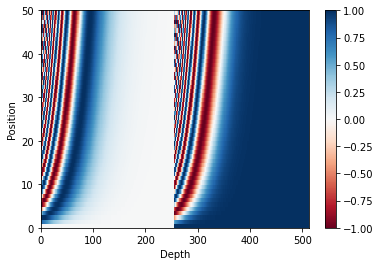

In [19]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Do we need an Encoder??

Generally, when we search for a transformer model we see that the architecture consists of both an encoder and a decoder. The reason is that the architectures are proposed for language conversion, like French to English etc. 

In such cases we have an Encoder that gets the original langauge as input and learns how to encode the language such that it can be understood by the decoder. This information is then passed on to the decoder which uses it to understand the semantic of the text to be generated. 

Thus, the decoder by itself is simply language text generator for target language and encoder is the semantic extractor for source language. 

Since in our case we don't need to pass any semantic knowledge to the decoder and only need to generate the text we will be skipping the encoder part in our transformer.

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [0]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)


  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

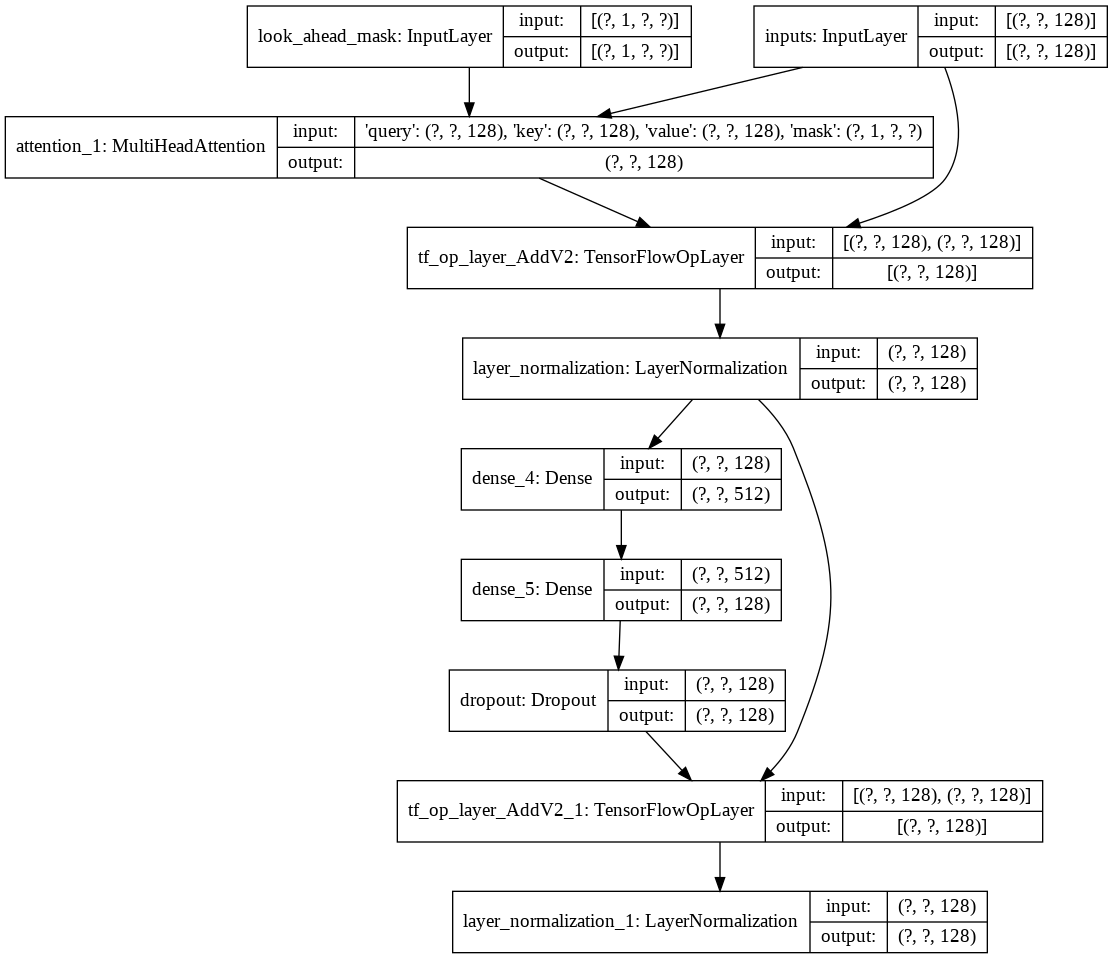

In [21]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [0]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='Language_Decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs,  look_ahead_mask])

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

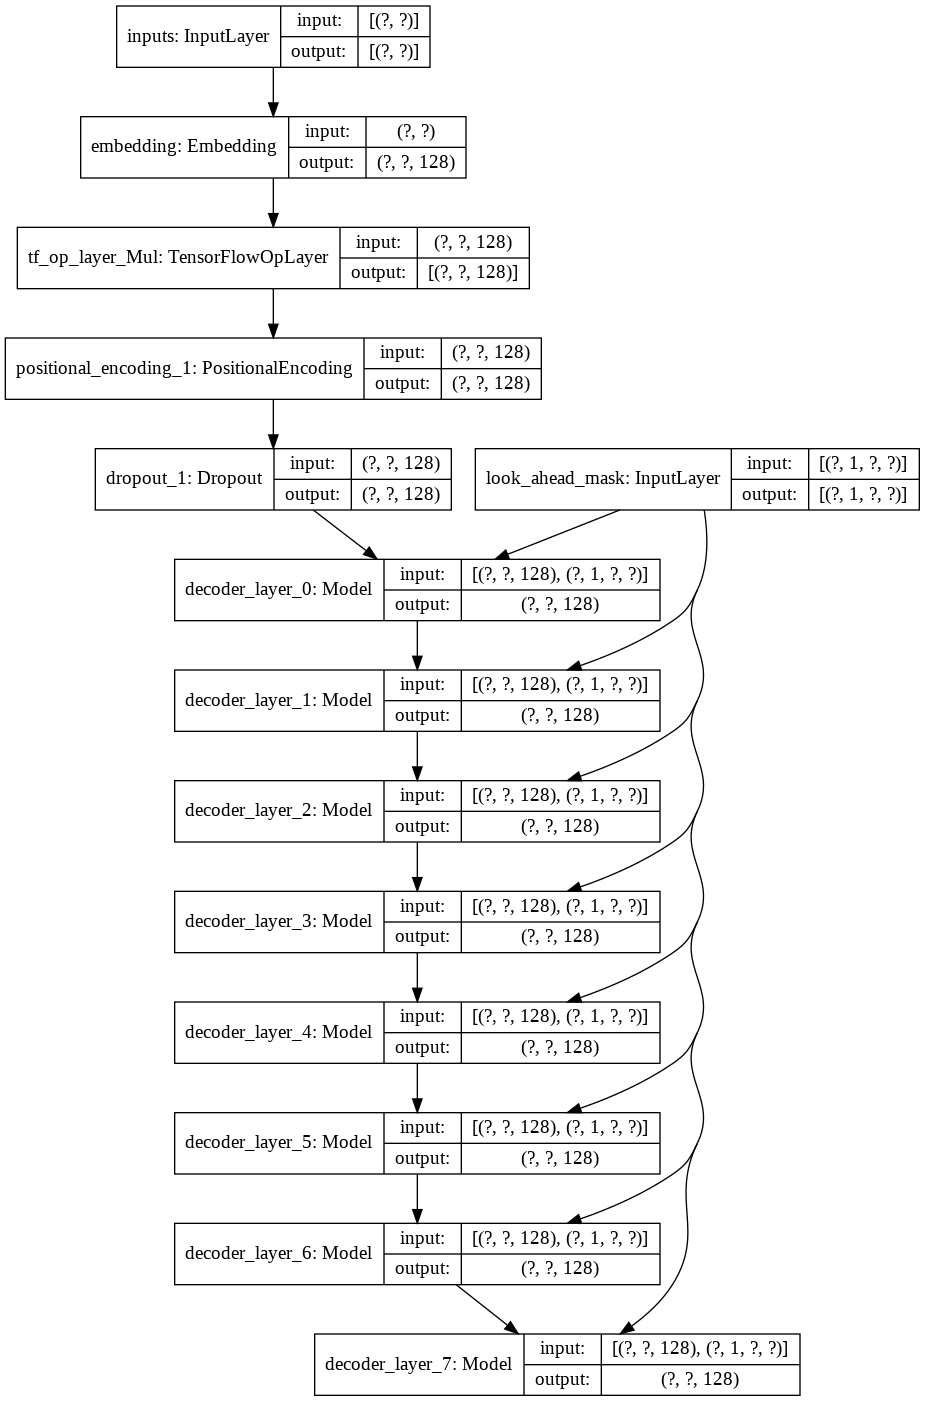

In [23]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=8,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [0]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      get_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)
 

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, look_ahead_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

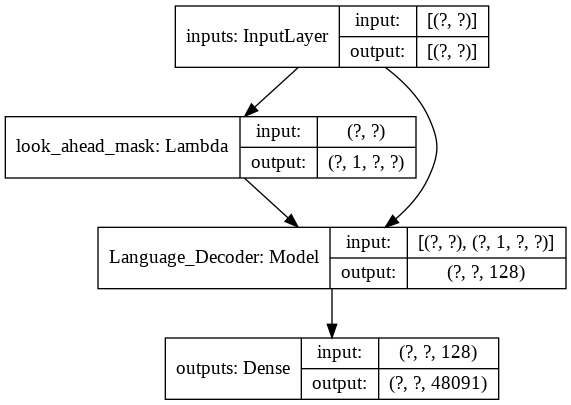

In [25]:
sample_transformer = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## Train model

### Initialize model



In [0]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 8
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [0]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

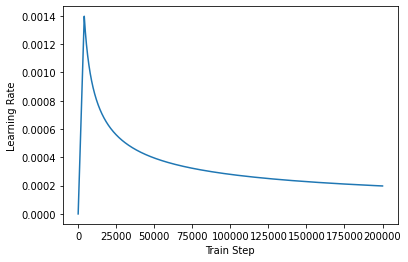

In [29]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Compile Model


In [0]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [31]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
Language_Decoder (Model)        (None, None, 256)    16528128    inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 48091)  12359387    Language_Decoder[1][0] 

## Checkpointing

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [33]:
EPOCHS = 10

model.fit(jokes_dataset, epochs=EPOCHS, callbacks = [checkpoint_callback])

Epoch 1/10
3620/3620 [==============================] - 1306s 361ms/step - loss: 2.2078 - accuracy: 0.0763
Epoch 2/10
3620/3620 [==============================] - 1298s 358ms/step - loss: 1.7876 - accuracy: 0.1056
Epoch 3/10
3620/3620 [==============================] - 1298s 359ms/step - loss: 1.6789 - accuracy: 0.1155
Epoch 4/10
3620/3620 [==============================] - 1299s 359ms/step - loss: 1.6185 - accuracy: 0.1218
Epoch 5/10
3620/3620 [==============================] - 1322s 365ms/step - loss: 1.5837 - accuracy: 0.1264
Epoch 6/10
3620/3620 [==============================] - 1327s 367ms/step - loss: 1.5570 - accuracy: 0.1301
Epoch 7/10
3620/3620 [==============================] - 1328s 367ms/step - loss: 1.5329 - accuracy: 0.1333
Epoch 8/10
3620/3620 [==============================] - 1321s 365ms/step - loss: 1.5124 - accuracy: 0.1359
Epoch 9/10
3620/3620 [==============================] - 1312s 363ms/step - loss: 1.4943 - accuracy: 0.1384
Epoch 10/10
3620/3620 [==============

## Inference

In [0]:
def exploit_best_token_while_exploring(probabilites, exploration_len=5):
    ## Get the top k probabilites indices where k is exploration_len 
    top_indices = np.argpartition(probabilites, -exploration_len)\
                            [-exploration_len:]

    ## Getting top proabilities value
    top_probabilities = probabilites[top_indices]
    
    ## Normalizing it so that they sum is 1
    top_probabilities = top_probabilities / np.sum(top_probabilities)
    ## Although we choose next token randomly for our options we 
    ## pass the probabilities associated with each to account for the
    ## model's confidence for the token also. 
    choice = np.random.choice(exploration_len, 1, p = top_probabilities)

    ## Return next token id based on choice
    next_token_id = int(top_indices[choice][0])
    return next_token_id

In [0]:
def complete_joke(sentence, MAX_LEN = 64):
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence), axis=0)
  

  for pos in range(MAX_LEN):
    predictions = model(sentence, training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[0, -1]
    softmax_logits = tf.nn.softmax(predictions, axis=0).numpy()

    ## Depending on whether we are in initial or final stages of joke
    ## we determine how many options we should explore to make sure we have
    ## variety in jokes generated
    if pos == 0:
      # If we are predicting first word we need maximum exploration
      exploration_len = 50

    elif pos < 4:
      # The next three words have exploration length 15
      exploration_len = 15

    else:
      # As we move further we narrow our exploration length
      exploration_len = 4

    predicted_id = exploit_best_token_while_exploring(softmax_logits, 
                                                         exploration_len)
    
    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]) or tf.equal(predicted_id, START_TOKEN[0]):
      return tokenizer.decode(tf.squeeze(sentence[:, 1:]).numpy())

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input in enxt iteration.
    sentence = tf.concat([sentence,tf.ones((1,1), dtype = tf.int32)*predicted_id], axis=-1)

  ## If we did not get end token it means no joke is formed and we try again
  return complete_joke(sentence)

In [0]:
complete_joke("It is ")

'It is good to be so good at making a joke. I just came up with "You know, you have the biggest dick."'

In [0]:
complete_joke("It is ")

'It is hard to explain puns to kleptomaniacs Because they always take things literally'

In [0]:
complete_joke("The joke is")

'The joke is /r/r/jokes is [removed]'

In [0]:
complete_joke("Life is not ")

"Life is not a box of chocolates... It's a joke."

In [0]:
complete_joke("Windows is ")

'Windows is bad. The number 7 was a joke.'

In [0]:
complete_joke("Am I the ")

"Am I the only one, the most important way to make a good joke? I don't know if it's a joke. I just want to be a joke here. I just made it up."

## Conclusion

Given that we have not used transfer learning and built it from scratch the model seems to performs reasonably well imho. More training and deeper networks could yield even better result.

You might be wondering how the jokes are looking reasonably well even when accuracy is only around 13%. The reason for this is that accuracy is not a good metric to judge language generation. Lets say we have only 2 texts in our dataset.

`It is good.`

`It is bad.`


Now lets say we are training our model for `It is`. Even if the model predicts `good` and `bad` as the top two probable outcomes which will ensure the loss will be low, but since only one of them will be having the highest probability, the accuracy can be only `50 %`. Thus with two texts having the same beginning string we have an upper bound of 50% for accuracy.